# Lab 2 - Classification
#### Yang Zhang, Reannan McDaniel, Jonathon Roach, Fred Poon
##### 06/28/2020
##### Machine Learning 1 | MSDS_7331

## Business Understanding
For this analysis, our group will be working with North Carolina Public Schools Report Card and Statistical Profiles Data sets from the years 2014 to 2017. These data sets encompass information across 4 continuous years of educational attributes in North Carolina, USA.  The data is collected from the State of North Carolina at [http://ncpublicschools.org](http://ncpublicschools.org) and made available from the Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools by Dr. Jake Drew. Among other reasons, the data was collected for evaluation of public-school performance for the purpose of efficiently allocating funds to various educational initiatives. Analyses of such data are important because high-impact educational initiatives that are well-funded contribute to increased graduation rates, increased achievement at the post-secondary level, less crime, and greater economic engagement among young people. For the purpose of this exercise, our focus is on predicting graduation rates using various school characteristics, such as type of school (elementary, middle, high, or some combination of the three), social demographics, economic demographics, and location between 2014 and 2017. The Belk Foundation's website says, "Our goal is to empower today’s workforce by creating pathways to and through postsecondary education for underrepresented students". -->

For the sake of this analysis, we assume that better performing schools have better outcomes in postsecondary education. With North Carolina's rapidly changing demographics, it is important to take into consideration schools' unique needs when allocating funds to strategic investment initiatives. Here, we explore where funding can be best applied based on educational achievement data.

We will explore through visual and mathematical modeling which features best predict the graduation rate. The analysis will come in a combination of classification models to predict. In this analysis we will observe:

- What classification model provides the higher accuracy score?

## Data Understanding

## Data Preparation 1 - The Variables
Two separate tasks are performed for the education dataset: The first is a classification task for SPG Grade, the second is a regression task for graduation rate. Because the target variables are different, different scopes/subsets of data are used for these tasks. Below we are introducting the data preparation stages of the two tasks separately.

In [3]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# For multiple line outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Data Preparation for Classification Task
#### Data Preparation Workflow
- Data Merge
- One Hot-encoding
- Feature Selection
- Data Balancing

#### Data Merge

We combined dataset of all public schools in north Carolina from year 2014-2017 together. We also add a variable "Year" to note the calendar year the data come from.

In [9]:
# read in CSV
df2014 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2014_MLnew.csv')
df2015 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2015_MLnew.csv')
df2016 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2016_MLnew.csv')
df2017 = pd.read_csv('https://raw.githubusercontent.com/fredpoon/ds_7331_jyrf_eda/master/Data_Prep/PublicSchools2017_MLnew.csv')

df2014.shape
df2015.shape
df2016.shape
df2017.shape


df2014['Year'] = 2014
df2015['Year'] = 2015 
df2016['Year'] = 2016 
df2017['Year'] = 2017 

frames = [df2014, df2015, df2016, df2017]
df_comb_test = pd.concat(frames,join='inner', ignore_index=True)

df_comb_test['Year']

(2426, 318)

(2432, 335)

(2430, 328)

(2443, 328)

0       2014
1       2014
2       2014
3       2014
4       2014
        ... 
9726    2017
9727    2017
9728    2017
9729    2017
9730    2017
Name: Year, Length: 9731, dtype: int64

#### One Hot-encoding

A one-hot encoding procedure has been conducted to convert all of them into continuous variables. The procedure is shown below: 8 variables with more than 25 unique values are deleted. 38 new variables has been generated from one hot-encoding of categorical variables.

In [10]:
schoolData = df_comb_test

#Locate the categorical variables in dataset
sD_nominal = schoolData.loc[:, (schoolData.dtypes == object)]
uniqueThreshold = 25

#Delete categorical columns with > 25 unique values (Each unique value becomes a column during one-hot encoding)
oneHotUniqueValueCounts = schoolData[sD_nominal.columns].apply(lambda x: x.nunique())
oneHotUniqueValueCols = oneHotUniqueValueCounts[oneHotUniqueValueCounts >= uniqueThreshold].index
schoolData.drop(oneHotUniqueValueCols, axis=1, inplace=True) 

#Review dataset contents one hot high unique value drops
print('*********After: Removing columns with >= uniqueThreshold unique values***********')
schoolData.info(verbose=False)
print ('\r\nColumns Deleted: ', len(oneHotUniqueValueCols))

*********After: Removing columns with >= uniqueThreshold unique values***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Columns: 250 entries, szip_ad to Year
dtypes: float64(237), int64(2), object(11)
memory usage: 18.6+ MB

Columns Deleted:  9


"SPG Grade" is our response variable and "SPG Score" is the continous expression of it. "SPG Score" is a composite score calculated from schools' average scores based on multiple assessments. The "SPG Grade" is converted from "SPG Score" by ranges. We have to remove them from the original dataset.

Per the analysis, we found that a few attributes were directly used to calculate our response variable. With this in mind, we'll remove these attributes from the dataset.  Features which are discarded include end-of-course, end-of-grade scores and any features related to EVAAS growth metrics. For example: EOG_XXX, EOC_XXX.

After removing them, we display the information of the variables to make sure we don't have them in the dataset anymore. We end up with 148 features in total.

In [11]:
#Keep an original copy of the Data
schoolData_org = schoolData

#Pop out the SPG information from the Data
schoolData_SPG = schoolData.pop('SPG Grade')
schoolData_SPGScore = schoolData.pop('SPG Score')

# Remove All the Columns that directly used to calculate SPG Grade and Score
schoolData.drop(schoolData.iloc[:, 21:162], inplace=True, axis=1)
schoolData.info(verbose=True)

#Isolate remaining categorical variables
begColumnCt = len(schoolData.columns)

#one hot encode categorical variables
schoolData = pd.get_dummies(data=schoolData,drop_first=True)

#Determine change in column count
endColumnCt = len(schoolData.columns)
columnsAdded = endColumnCt - begColumnCt

#Review dataset contents one hot high unique value drops
print('Columns To One-Hot Encode: ', len(sD_nominal.columns))
print('\r\n*********After: Adding New Columns Via One-Hot Encoding*************************')
schoolData.info(verbose=False)
print ('\r\nNew Columns Created Via One-Hot Encoding: ', columnsAdded)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9731 entries, 0 to 9730
Data columns (total 107 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   szip_ad                              float64
 1   category_cd                          object 
 2   calendar_type_txt                    object 
 3   sna_pgm_type_cd                      object 
 4   school_type_txt                      object 
 5   calendar_only_txt                    object 
 6   title1_type_cd                       object 
 7   esea_status                          object 
 8   student_num                          float64
 9   lea_avg_student_num                  float64
 10  st_avg_student_num                   float64
 11  Grad_project_status                  object 
 12  Math I_Size                          float64
 13  lea_total_expense_num                float64
 14  lea_salary_expense_pct               float64
 15  lea_services_expense_pct             

#### Feature Selection

We original have 148 features in the data table. We don't want to include this many features for model feasibility. However, as we have a data size requirement, and we also want the constructing model to be high quality. We decide to conduct a feature selection process to choose the most important features to use.

There are many ways to conduct feature selection. In this project we use random forest and plot out feature importances of all features. Note that the work below is not for feasible model construction (we didn't split train/test) but just for picking out the most important variables to use.  

In [ ]:
# Random Forest apply to X with all variables
from sklearn.ensemble import RandomForestClassifier
clfa=RandomForestClassifier(n_estimators=100)
clfa.fit(schoolData,schoolData_SPG)
y_pred=clfa.predict(schoolData)

#For feature importance from RandomForestClassifier()
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clfa, random_state=1).fit(schoolData,schoolData_SPG)
eli5.show_weights(perm, feature_names = schoolData.columns.tolist(), top=50)

To meet the data size requirement, we need to have as least 450,000/9371 = 48 attributes to use for the data. Above, we used RandomForestClassifer for the purpose of feature selection and each feature importance to identify which attributes to keep and/or remove from our dataset.

To satisfy this we pick the first 50 attributes to use. Notice that in the below attributes list there are both continuous attributes and the categorical attributes after one-hot encoding. 

In [12]:
#Pick and Choose variables
schoolData_pick = schoolData[[
'TotalTargets_pTarget_PctMet',
'MinorityMalePct',
'MinorityFemalePct',
'short_susp_per_c_num',
'avg_daily_attend_pct',
'title1_type_cd_Y',
'BlackMalePct',
'AsianFemalePct',
'BlackFemalePct',
'HispanicMalePct',
'MathGr3-8_pTarget_PctMet',
'AsianMalePct',
'SciGr5&8_pTarget_PctMet',
'nbpts_num',
'lea_sat_avg_score_num',
'stud_internet_comp_num',
'st_avg_student_num',
'HispanicFemalePct',
'Accomplished_TCHR_Standard 4_Pct',
'Accomplished_TCHR_Standard 3_Pct',
'Developing_TCHR_Standard 2_Pct',
'Accomplished_TCHR_Standard 5_Pct',
'10+ Years_LEA_Exp_Pct_Prin',
'4-10 Years_LEA_Exp_Pct_Prin',
'Accomplished_TCHR_Standard 1_Pct',
'Accomplished_TCHR_Standard 2_Pct',
'Developing_TCHR_Standard 1_Pct',
'pct_GCE_ALL',
'0-3 Years_LEA_Exp_Pct_Prin',
'st_emer_prov_teach_pct',
'lea_sat_participation_pct',
'lea_ap_participation_pct',
'lea_federal_perpupil_num',
'lea_local_perpupil_num',
'advance_dgr_pct',
'Developing_TCHR_Standard 5_Pct',
'lateral_teach_pct',
'lea_flicensed_teach_pct',
'Developing_TCHR_Standard 3_Pct',
'lea_tchyrs_0thru3_pct',
'lea_tchyrs_11plus_pct',
'lea_nbpts_num',
'lea_advance_dgr_pct',
'lea_1yr_tchr_trnovr_pct',
'lea_emer_prov_teach_pct',
'st_flicensed_teach_pct',
'st_tchyrs_0thru3_pct',
'st_1yr_tchr_trnovr_pct',
'lea_tchyrs_4thru10_pct',
'Category_Cd_T',
]]

# Dataset Dimension with picked variables
schoolData_pick.shape

(9731, 50)

#### Data Balancing

Before identifying the data balancing need, we first conducted a simplied procedure to our response variable (SPG_Grade). We investigate the current class of the SPG Grade and found that the class "A" and "A+NG" are identical so we merge the two.Notice that magnet schools in 2016-2017 are not required to report SPG score. Those schools with incomplete information are marked "I". the class "I" are removed from the dataset.

The grade C is dominate the dataset with the largest propertion, followed by B or D. A and F are just a small propertion of the whole dataset. 

,0
count,9216
unique,5
top,C
freq,3973


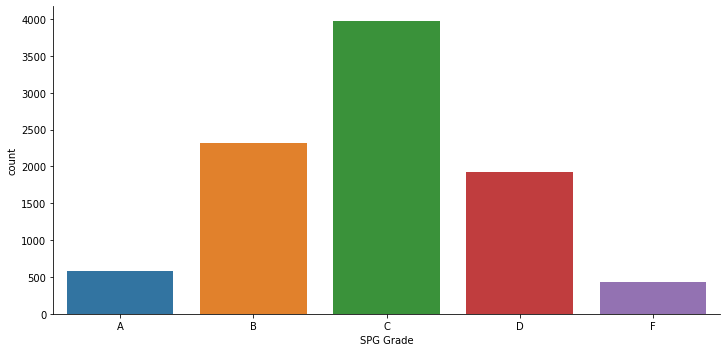

In [13]:
schoolData_SPG_org = schoolData_SPG
schoolData_SPG = schoolData_SPG_org

import numpy as np
schoolData_SPG= np.select(
    [
        schoolData_SPG == 'A', 
        schoolData_SPG == 'B',
        schoolData_SPG == 'C',
        schoolData_SPG == 'D',
        schoolData_SPG == 'F',
        schoolData_SPG == 'A+NG',
        schoolData_SPG == 'I'
    ], 
    [
        'A', 
        'B',
        'C',
        'D',
        'F',
        'A',
        'NA'
    ],
    default='NA'
)

#Filter out the sample with "NA" on SPG Grade
schoolData_SPG_new = schoolData_SPG[schoolData_SPG!='NA']
schoolData_pick_new = schoolData_pick[schoolData_SPG!='NA']

# Check if the levels of SPG Grade has been altered
s = pd.DataFrame(schoolData_SPG_new)
s.describe()

#Factor Plot for SPG Grade
s.columns=['SPG Grade']
                        
sns.factorplot("SPG Grade", data=s, aspect=2,
                       kind="count", order=['A','B','C','D','F'])

plt.show()

To solve this problem, we are using the crieteria below. We conduct 3 seperate procedures: UnderSample all cases, UnderSample majority class, SMOTE Oversample.

They produce 3 seperate sets of X and y from the original dataset. Those sets will be evaluate against each other and we will decide the best data balancing strategy to use.

In [14]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the dataset using the RandomUnderSampler 
# Set all class sizes equal to the smallest class.
us = RandomUnderSampler()
X_us, y_us = us.fit_sample(schoolData_pick_new, pd.DataFrame(schoolData_SPG_new))

# Undersample the dataset using the RandomUnderSampler 
# Undersample the majority class only
us = RandomUnderSampler(sampling_strategy='majority')
X_us_maj, y_us_maj = us.fit_sample(schoolData_pick_new, pd.DataFrame(schoolData_SPG_new))

from imblearn.over_sampling import SMOTE

# Oversample using SMOTE
# Make all classes the same size as the majority class.
# WARNING - This can exponentially increase the size of the input dataset.
sm = SMOTE(sampling_strategy='not majority')
X_sm, y_sm = sm.fit_sample(schoolData_pick_new, pd.DataFrame(schoolData_SPG_new))

By comparing the results for the 3 different methods dealing with data imbalance, we run random forest with the datasets we generated. Accuracy are measured with the results of the variables. As shown the SMOTE strategy get the highest accuracy which is 20%+ than the undersample strategy. Due to the effectiveness of the SMOTE strategy, the dataset has been chosen for creating models in the next session, we also conduct modeling on the original data for benchmarking. 

In [155]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
#Training using Undersample Method1     

X_train, X_test, y_train, y_test = train_test_split(X_us, y_us, test_size=0.2, random_state=42)

clfus=RandomForestClassifier(n_estimators=100)
clfus.fit(X_train,y_train)
y_pred_us=clfus.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_us))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.6697674418604651


In [157]:
#Training using Undersample Method2

X_train, X_test, y_train, y_test = train_test_split(X_us_maj, y_us_maj, test_size=0.2, random_state=42)
    
clfusm=RandomForestClassifier(n_estimators=100)
clfusm.fit(X_train,y_train)
y_pred_usm=clfusm.predict(X_test)
    
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_usm))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.7841409691629956


In [158]:
#Training using Oversample Method

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

clfsm=RandomForestClassifier(n_estimators=100)
clfsm.fit(X_train,y_train)
y_pred_sm=clfsm.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_sm))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.874653913918953


#### Data Scaling and Dimension Reduction

By applying standard scalers to the dataset, we transformed the original features to the ranges between -1 and 1. An important usage of the scaled varaibles is for feature importance.

A simple test of random forest has been conducted using random forest to see any impact to model accuracy. The resulted accuracy (0.878) is approximately the same (slightly higher) with unscaled data (0.875).

In [120]:
from sklearn.preprocessing import StandardScaler
# Scale the data 
ss = StandardScaler()
X_sm_scal = ss.fit_transform(X_sm)
X_sm_scal = pd.DataFrame(X_sm_scal)

In [159]:
#Training using Oversample Method

X_train, X_test, y_train, y_test = train_test_split(X_sm_scal, y_sm, test_size=0.2, random_state=42)

clfsm_scal=RandomForestClassifier(n_estimators=100)
clfsm_scal.fit(X_train,y_train)
y_pred_sm_scal=clfsm_scal.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_sm_scal))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.876919204631261


A PCA step has been conducted on the scaled dataset and 50 PCA components are generated. By examining the plot below we identified that 40 components can already explain 98%+ of the variables. We experiment on just use 40 components to fit a random forest model as above and get a comparable accuracy (0.875).

It indicates that only 40 variables (PCA components) are good representatives of the information. They can be used as a replacement for all 50 variables in the later modeling procedure.

Cumulative Explained variance at 200 components: 1.0000000000000002


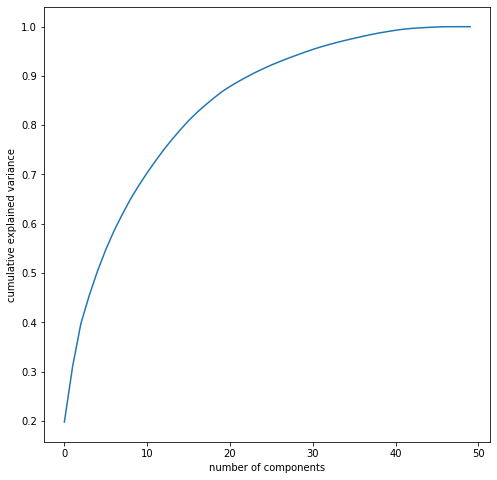

In [43]:
def plot_pca(X):
    # Perform PCA on the data to reduce the number of initial features 
    # and to remove correlations that are common between pixel features 
    pca = PCA(n_components=X.shape[1])
    pca.fit(X)

    # Inspect the explained variances to determine how many components to use  
    plt.subplots(figsize=(8, 8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    print('Cumulative Explained variance at 200 components:',sum(pca.explained_variance_ratio_[0:49]) )

plot_pca(X_sm_scal)

In [160]:
# Convert X_sm to 200 principal components
pca = PCA(n_components=40)
X_sm_pca40 = pca.fit_transform(X_sm_scal)

#Training using Oversample Method
X_train, X_test, y_train, y_test = train_test_split(X_sm_pca40, y_sm, test_size=0.2, random_state=42)

clfsm=RandomForestClassifier(n_estimators=100)
clfsm.fit(X_train,y_train)
y_pred_sm=clfsm.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_sm))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Accuracy: 0.8447017367228794


### Data Preparation for Regression Task

Now let's deal with the dataset for the regression task.

For Education Dataset, we choose the Graduration Rate as our response variable for this regression task. Because only high school have valid graduration rate variables, we choose to start with 2014-2017 high school datasets below. One hot-encoding procedure has been conducted similiarly with the dataset above. 

Data Preparation Workflow
- Data Merge
- Feature Selection
- Dimension Reduction

#### Data Merge

We combined dataset of all high schools in north Carolina from year 2014-2017 together. We also add a variable "Year" to note the calendar year the data come from.

In [24]:
# read in CSV
df2014 = pd.read_csv('C:/Users/taniat470s/Desktop/SMU_course/DS7331/EduData/EducationDataNC/2014/Machine Learning Datasets/PublicHighSchools2014_ML.csv')
df2015 = pd.read_csv('C:/Users/taniat470s/Desktop/SMU_course/DS7331/EduData/EducationDataNC/2015/Machine Learning Datasets/PublicHighSchools2015_ML.csv')
df2016 = pd.read_csv('C:/Users/taniat470s/Desktop/SMU_course/DS7331/EduData/EducationDataNC/2016/Machine Learning Datasets/PublicHighSchools2016_ML.csv')
df2017 = pd.read_csv('C:/Users/taniat470s/Desktop/SMU_course/DS7331/EduData/EducationDataNC/2017/Machine Learning Datasets/PublicHighSchools2017_ML.csv')

df2014.shape
df2015.shape
df2016.shape
df2017.shape

df2014['Year'] = 2014
df2015['Year'] = 2015 
df2016['Year'] = 2016 
df2017['Year'] = 2017 

frames = [df2014, df2015, df2016, df2017]
df_comb_test = pd.concat(frames,join='inner', ignore_index=True)

df_comb_test['Year']

(476, 351)

(480, 412)

(478, 373)

(470, 403)

0       2014
1       2014
2       2014
3       2014
4       2014
        ... 
1899    2017
1900    2017
1901    2017
1902    2017
1903    2017
Name: Year, Length: 1904, dtype: int64

We remove the variables that are directly related to Graduation Rates as shown below:

In [25]:
schoolData = df_comb_test

#Remove schools with graduation rates == 0 from the model
schoolData = schoolData[schoolData['GraduationRate_5yr_All'] > 0]

#Find Response Variable
schoolData_GraduationRate_5yr = schoolData.GraduationRate_5yr_All

# Remove any columns from the model's training data that are directly related to the graduation rate. 
GradRateCols = schoolData.columns[schoolData.columns.str.lower().str.contains('graduation')]
GradRateCols

Index(['GraduationRate_5yr_All', 'GraduationRate_4yr_Female',
       'GraduationRate_5yr_Female', 'GraduationRate_4yr_Male',
       'GraduationRate_5yr_Male', 'GraduationRate_4yr_AmericanIndian',
       'GraduationRate_5yr_AmericanIndian', 'GraduationRate_4yr_Asian',
       'GraduationRate_5yr_Asian', 'GraduationRate_4yr_Black',
       'GraduationRate_5yr_Black', 'GraduationRate_4yr_Hispanic',
       'GraduationRate_5yr_Hispanic', 'GraduationRate_4yr_TwoorMoreRaces',
       'GraduationRate_5yr_TwoorMoreRaces', 'GraduationRate_4yr_White',
       'GraduationRate_5yr_White', 'GraduationRate_4yr_EDS',
       'GraduationRate_5yr_EDS', 'GraduationRate_4yr_LEP',
       'GraduationRate_5yr_LEP', 'GraduationRate_4yr_SWD',
       'GraduationRate_5yr_SWD', 'GraduationRate_4yr_AIG',
       'GraduationRate_5yr_AIG'],
      dtype='object')

In [45]:
#Delete the response variable and other graduation rate data columns from our training dataset
X_predGradRate = schoolData.drop(GradRateCols, axis=1)

Y_GradRate = schoolData_GraduationRate_5yr

#### Feature Selection

To test if there's redundant variables in the dataset, we decide to conduct a feature selection process to eliminate the least important features. 

There are many ways to conduct feature selection. In this project we use random forest and plot out feature importances of all features. Note that the work below is not for feasible model construction (we didn't split train/test) but just for picking out the most important variables to use.  

Below is a benchmarking modeling we did using random forest regressor. The "default" MAE value is 4.91.

In [138]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

rfr = RandomForestRegressor()
#rfr.fit(X_predGradRate, Y_GradRate)

scores = cross_val_score(rfr, X_predGradRate, Y_GradRate, cv=3, scoring='neg_mean_absolute_error')
predictions = cross_val_predict(rfr, X_predGradRate, Y_GradRate, cv=3)

#MAE
np.sqrt(mean_squared_error(Y_GradRate, predictions))

4.914862122261348

In [131]:
#For feature importance from RandomForestRegressor()
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rfr, cv = None, refit = True, n_iter = 50).fit(X_predGradRate,Y_GradRate)

NameError: name 'imp_df' is not defined

In [137]:
eli5.show_weights(perm, feature_names = X_predGradRate.columns.tolist(), top=263)

Weight,Feature
0.5750 ± 0.0428,SPG Score
0.0698 ± 0.0054,short_susp_per_c_num
0.0486 ± 0.0051,student_num
0.0334 ± 0.0029,avg_daily_attend_pct
0.0316 ± 0.0042,lea_local_perpupil_num
0.0142 ± 0.0015,EOCSubjects_CACR_All
0.0135 ± 0.0010,TotalTargets_pTarget_PctMet
0.0089 ± 0.0009,BlackFemalePct
0.0081 ± 0.0011,ACTWorkKeys_SilverPlus_Black
0.0080 ± 0.0010,lea_avg_student_num


By above weights information, we identified the variables with weight "0", which are with least feature importance. We are filtering out those variables as shown below: 

In [140]:
LightWeight_Cols = X_predGradRate[[
'EOCBiology_CACR_AmericanIndian',
'EOCEnglish2_CACR_AmericanIndian',
'EVAAS Growth Status_NotMet',
'ACTWorkKeys_SilverPlus_Asian',
'grade_range_cd_9-13',
'calendar_type_txt_Regular School, Year-Round Calendar',
'ACTMath_ACTBenchmark_AmericanIndian',
'ACTScience_ACTBenchmark_LEP',
'Not Demostrated_TCHR_Standard 1_Pct',
'ACTWriting_ACTBenchmark_AmericanIndian',
'ACTReading_ACTBenchmark_LEP',
'Not Demostrated_TCHR_Standard 4_Pct',
'ACTMath_ACTBenchmark_LEP',
'grade_range_cd_7-12',
'grade_range_cd_K-12',
'grade_range_cd_7-13',
'grade_range_cd_8-12',
'grade_range_cd_PK-12',
'grade_range_cd_9-9',
'grade_range_cd_6-13',
'grade_range_cd_11-12',
'grade_range_cd_9-11',
'ACTWorkKeys_SilverPlus_LEP',
]]
#radRateCols = schoolData.columns[schoolData.columns.str.lower().str.contains('graduation')]
#   X_predGradRate = schoolData.drop(GradRateCols, axis=1)

In [141]:
X_predGradRate_pick = X_predGradRate.drop(LightWeight_Cols, axis=1)

In [143]:
X_predGradRate_pick.shape

(1811, 240)

After variable elimination we have 240 features left, we did another modeling and the MAE is 4.93, which is similiar with before. We can assume the elimination is proper.

In [144]:
predictions = cross_val_predict(rfr, X_predGradRate_pick, Y_GradRate, cv=3)

#MAE
np.sqrt(mean_squared_error(Y_GradRate, predictions))

4.9359213498656604

#### Dimension Reduction

A PCA step has been conducted on the scaled dataset and a total of 240 PCA components are generated. By examining the plot below we identified that 200 components can already explain 99%+ of the variables. We experiment on just use 200 components to fit a elastic net model that has an error similiar with all 240 variables.

It indicates that only 200 variables (PCA components) are good representatives of the information. They can be used as a replacement for all 240 variables in the later modeling procedure.

Cumulative Explained variance at 200 components: 0.9952688254101744


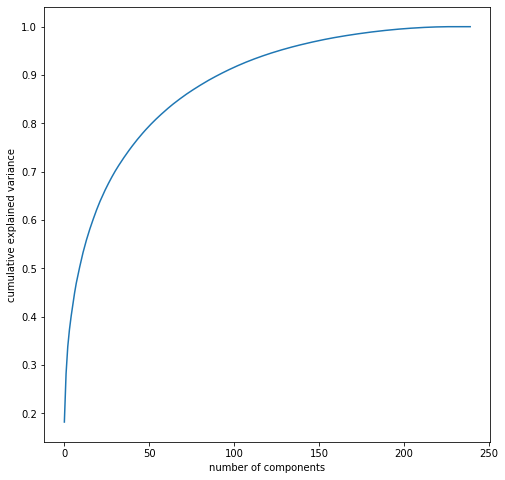

In [147]:
X_predGradRate_scal = ss.fit_transform(X_predGradRate_pick)

plot_pca(X_predGradRate_scal)

In [148]:
# Convert X_sm to 200 principal components
pca = PCA(n_components=200)
X_predGradRate_pca200 = pca.fit_transform(X_predGradRate_scal)

Only 200 variables (PCA components) give MAE of 5.3, which is slightly higher than using all 240 variables.

In [149]:
predictions = cross_val_predict(rfr, X_predGradRate_pca200, Y_GradRate, cv=3)
np.sqrt(mean_squared_error(Y_GradRate, predictions))

5.3035661845480755

## Data Preparation 2 - The Dataset

Below we describe the final dataset used for the classification and regression tasks. Only the features selected in the above process are listed and describled.

In the following sessions, evaluation metrics are introduced specifically for the two tasks.

### Data Description for Classification Task

The data set contains 9,731 records and 259 attributes that are comprised of factors, numbers, and characters. A data definition sheet can be found in Dr. Drew's github repository, [https://github.com/jakemdrew/EducationDataNC](https://github.com/jakemdrew/EducationDataNC/tree/master/Data%20Documentation). To scale the data to be more manageable, our data set includes 50 of the 259 attributes. 

These variables were chosen after initial EDA and correlation visuals were generated between SPG and all predictors. The data type, category and description are displayed in the following table.

### Attributes
| Attribute | DataType | Description |
|:---|:---|:---|
| SPG Grade                          | object  | School Performance Grade (Letter Grade - A-D, F) |
| MinorityMalePct                    | float64 | Minority Male Perentage |
| MinorityFemalePct                  | float64 | Minority Female Percentage |
| short_susp_per_c_num               | float64 | Short term suspensions per 100 students at school level |
| avg_daily_attend_pct               | float64 | Average daily attendance percentage at school level |
| title1_type_cd_Y                   | uint8   | Title 1 Status |
| BlackMalePct                       | float64 | Black Male Percentage |
| AsianFemalePct                     | float64 | Asian Female Percentage |
| BlackFemalePct                     | float64 | Black Female Percentage |
| TotalTargets_pTarget_PctMet        | float64 | Percentage of total targets met |
| HispanicMalePct                    | float64 | Hispanic Male Percentage |
| MathGr3-8_pTarget_PctMet           | float64 | Percentage of students meeting Math target in grade levels 3 thru 8 |
| AsianMalePct                       | float64 | Asian Male Percentage |
| SciGr5&8_pTarget_PctMet            | float64 | Percentage of students meeting Science target in grade level 5 & 8 |
| nbpts_num                          | float64 | Number of National Board Certified Staff at school level |
| lea_sat_avg_score_num              | float64 | Average SAT score at LEA level |
| stud_internet_comp_num             | float64 | Ratio of students to internet connected computer at school level |
| st_avg_student_num                 | float64 | Average school size within the State |
| HispanicFemalePct                  | float64 | Hispanic Female Percentage |
| Accomplished_TCHR_Standard 4_Pct   | float64 | Percentage of accomplished teachers with teacher evaluation value of 4 |
| Accomplished_TCHR_Standard 3_Pct   | float64 | Percentage of accomplished teachers with teacher evaluation value of 3 |
| Developing_TCHR_Standard 2_Pct     | float64 | Percentage of developing teachers with teacher evaluation value of 2 |
| Accomplished_TCHR_Standard 5_Pct   | float64 | Percentage of accomplished teachers with teacher evaluation value of 5 |
| 10+ Years_LEA_Exp_Pct_Prin         | float64 | Percentage of principle with more than 10 years of experience at the LEA level |
| 4-10 Years_LEA_Exp_Pct_Prin        | float64 | Percentage of principle with 4-10 years of experience at the LEA level |
| Accomplished_TCHR_Standard 1_Pct   | float64 | Percentage of accomplished teachers with teacher evaluation value of 1 |
| Accomplished_TCHR_Standard 2_Pct   | float64 | Percentage of accomplished teachers with teacher evaluation value of 2 |
| Developing_TCHR_Standard 1_Pct     | float64 | Percentage of developing teachers with teacher evaluation value of 1 |
| pct_GCE_ALL                        | float64 | Percentage of Third Grade Students Passed with Good Cause Exemption |
| 0-3 Years_LEA_Exp_Pct_Prin         | float64 | Percentage of principle with 0-3 years of experience at the LEA level |
| st_emer_prov_teach_pct             | float64 | Emerging teachers at State level |
| lea_sat_participation_pct          | float64 | Percentage of HS students taking an SAT exam at the LEA level |
| lea_ap_participation_pct           | float64 | Advanced Placement participation at LEA level |
| lea_federal_perpupil_num           | float64 | Federal expense per pupil at LEA level |
| lea_local_perpupil_num             | float64 | Local expense per pupil at LEA level |
| advance_dgr_pct                    | float64 | Percent of teachers with masters or higher degree at school dgr |
| Developing_TCHR_Standard 5_Pct     | float64 | Percentage of teacher with level 5 in Developing |
| lateral_teach_pct                  | float64 | Lateral entry teacher percentage at school level |
| lea_flicensed_teach_pct            | float64 | Average Percent of Teachers that meet NC fully licensed |
| Developing_TCHR_Standard 3_Pct     | float64 | Percentage of teacher with level 3 in Developing |
| lea_tchyrs_0thru3_pct              | float64 | LEA level Teacher experiences 0 to 3 years  |
| lea_tchyrs_11plus_pct              | float64 | LEA level Teacher experiences over 11 years |
| lea_nbpts_num                      | float64 | Average number of National Board Certified staff at LEA |
| lea_advance_dgr_pct                | float64 | Average percent of teachers with masters or higher degree at LEA level |
| lea_1yr_tchr_trnovr_pct            | float64 | One Year Teacher turnover percentage at school level |
| lea_emer_prov_teach_pct            | float64 | Emerging teachers at LEA level |
| st_flicensed_teach_pct             | float64 | Average Percent of Teachers that meet NC fully licensed |
| st_tchyrs_0thru3_pct               | float64 | Percentage of teachers with 4-10 years of experience at the State level |
| st_1yr_tchr_trnovr_pct             | float64 | Standardize One Year Teacher turnover percentage at school level |
| lea_tchyrs_4thru10_pct             | float64 | Percentage of teachers with 4-10 years of experience at the LEA level |
| Category_Cd_T                      | uint8   | School with Category code T (School has middle and high school grades) |

#### Data Description for Regression Task

The data set contains 1,811 records and 240 attributes that are comprised of factors, numbers, and characters. A data definition sheet can be found in Dr. Drew's github repository, [https://github.com/jakemdrew/EducationDataNC](https://github.com/jakemdrew/EducationDataNC/tree/master/Data%20Documentation). Because we need at least 40,000 records for this task, we are using all the attributes for this regression task. 

The data type, category and description are displayed in the following table.
### Attributes
| Attribute | DataType | Description |

to be added!!!!!!!

In [151]:
X_predGradRate_pick.describe()
X_predGradRate_pick.shape

,student_num,lea_avg_student_num,st_avg_student_num,Biology_Size,English II_Size,Math I_Size,lea_total_expense_num,lea_salary_expense_pct,lea_services_expense_pct,lea_supplies_expense_pct,...,grade_range_cd_6-12,grade_range_cd_9-12,esea_status_P,Grad_project_status_Y,SPG Grade_B,SPG Grade_C,SPG Grade_D,EVAAS Growth Status_Met,unit_code,Year
count,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,...,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000,1811.000000
mean,877.722253,832.858642,832.726118,18.930425,19.615130,18.453341,9084.812656,0.669730,0.081085,0.081854,...,0.013805,0.813363,0.034787,0.406405,0.341248,0.402540,0.088349,0.321369,507337.515737,2015.493650
std,585.214712,348.911687,94.675672,5.208325,5.124998,5.340805,1172.136628,0.094682,0.016434,0.015835,...,0.116711,0.389728,0.183292,0.491298,0.474259,0.490545,0.283880,0.467131,278643.806890,1.113125
min,16.000000,105.000000,252.000000,0.000000,0.000000,0.000000,7282.190000,0.547000,0.047000,0.028000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10303.000000,2014.000000
25%,366.500000,598.000000,837.000000,16.000000,17.000000,16.000000,8362.900000,0.611000,0.069000,0.072000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,280304.000000,2015.000000
50%,813.000000,812.000000,848.000000,19.000000,20.000000,19.000000,8821.640000,0.626000,0.081000,0.082000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,490362.000000,2015.000000
75%,1236.500000,974.000000,853.000000,23.000000,23.000000,22.000000,9405.800000,0.655000,0.089000,0.092000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,760369.000000,2016.000000
max,2966.000000,1852.000000,860.000000,32.000000,35.000000,37.000000,17801.850000,0.878000,0.153000,0.143000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,995330.000000,2017.000000


(1811, 240)

## Modeling and Evaluation
### Model Evaluation 1: Evaluation Matrix

#### Evaluation Matrix for classification task:
- Accuracy
- Accuracy of each class
- Confusion Matrix
- ROC curves of each class and all classes
- Optional: Precision and Recall

Below we demonstrate the usage of the matrix by results from the above Random Forest classifer and SMOTE data.

Accuracy, Precision and Recall

In [76]:
# Compare input and predictions
y=y_test
yhat=y_pred_sm

# get various measures of performance
total_accuracy = mt.accuracy_score(y, yhat)

rec_tot = []
prec_tot = []

for cls in np.unique(y):
    idx = (y==cls) # get classes
    ytmp_actual = np.zeros(y.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y.shape) # binary prediction array
    ytmp_predicted[yhat==cls] = 1
    
    #num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)

print ('Total Accuracy:',total_accuracy)
print ('Recalls for each class:',rec_tot)
print ('Precisions for each class:',prec_tot)

Total Accuracy: 0.8751573118550214
Recalls for each class: [0.9831121833534379, 0.8329177057356608, 0.7179802955665024, 0.875, 0.9728997289972899]
Precisions for each class: [0.9588235294117647, 0.8267326732673267, 0.786774628879892, 0.8440925700365408, 0.953519256308101]


Accuracy Measurements and Plot for each class

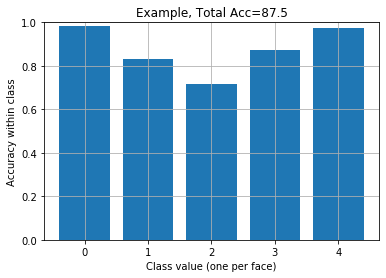

In [78]:
def per_class_accuracy(y,yhat):
    conf = mt.confusion_matrix(y,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Class value (one per face)')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.ylim([0,1])
    plt.show()
 

plot_class_acc(y,yhat,title="Example")

Confusion Matrix

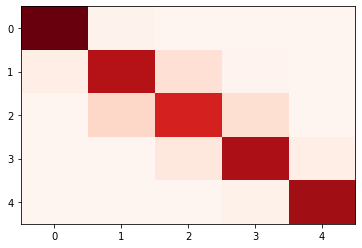

In [79]:
# how about plotting a confusion matrix?
cm = mt.confusion_matrix(y, yhat)
plt.imshow(cm,cmap=plt.get_cmap('Reds'),aspect='auto')
plt.grid(False)

ROC curves of each class and overall ROC curve

In [81]:
# Probability Matrix
yhat_score = clfsm.predict_proba(X_test)
yhat_score

array([[0.02, 0.29, 0.47, 0.22, 0.  ],
       [0.02, 0.91, 0.06, 0.01, 0.  ],
       [0.  , 0.01, 0.12, 0.28, 0.59],
       ...,
       [0.  , 0.02, 0.17, 0.81, 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.99],
       [0.07, 0.21, 0.52, 0.19, 0.01]])

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

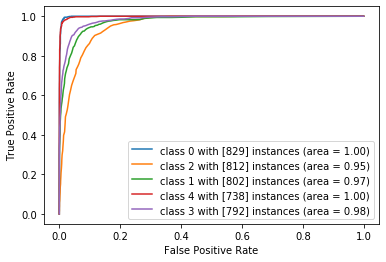

In [98]:
# Compute ROC curve for a subset of interesting classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in np.unique(y):
    fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
    roc_auc[i] = mt.auc(fpr[i], tpr[i])
    
for i in np.random.permutation(5)[0:5]:
    plt.plot(fpr[i], tpr[i], label='class {0} with {1} instances (area = {2:0.2f})'
                                   ''.format(i, sum(y==i), roc_auc[i]))

plt.legend(loc="lower right")  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [100]:
from sklearn.preprocessing import label_binarize
one_hot_class_encoding = label_binarize(y,np.unique(y))
one_hot_class_encoding

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0]])

In [107]:
fpr["micro"], tpr["micro"], _ = mt.roc_curve(one_hot_class_encoding.ravel(), yhat_score.ravel())
roc_auc["micro"] = mt.auc(fpr["micro"], tpr["micro"])

<Figure size 864x288 with 0 Axes>

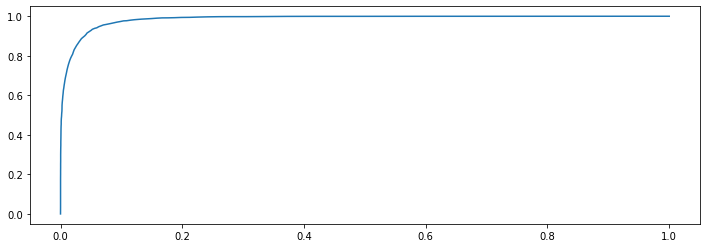

In [108]:
plt.figure(figsize=(12,4))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

#### Evaluation Matrix for regression task:
- MAE
- RMSE 
- MAPE

As shown below, MAE, RMSE and MAPE are chosen to evaluate the model performance. Below are the functions that will be used in model creation and evaluation sessions.

In [53]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=42)

In [52]:
#The below function reference to https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

In [54]:
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

### Model Evaluation 2: Training/Testing Split

To conduct cross-validation for our model robustness, we need to split the dataset into training and testing set. Below we show two criterias we use in later experiment for the splitting:
- ShuffleSplit
- Stratified Split

In ShuffleSplit we use a proportion of 80/20 for the training/testing dataset.
For stratified K fold splitting, we split the dataset to 10 folds, each contains 10% of the whole dataset.

Both splits are set to the same random_state number.

#### For classification task:

In [152]:
# Using ShuffleSplit for Training/Testing Split 
from sklearn.model_selection import ShuffleSplit

num_cv_iterations = 3
num_instances = len(schoolData_SPG)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2,random_state=42)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=42, test_size=0.2, train_size=None)


In [153]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

# create cross validation iterator
cv_stra = StratifiedKFold(n_splits=10,random_state=42)

print(cv_stra)

StratifiedKFold(n_splits=10, random_state=42, shuffle=False)


#### For regression task:

In [161]:
# Using ShuffleSplit for Training/Testing Split 
from sklearn.model_selection import ShuffleSplit


num_cv_iterations = 10
num_instances = len(Y_GradRate)
cv_object_reg = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2,random_state=42)
                         
print(cv_object_reg)

ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None)


### Exceptional Work
<!-- Gridsearch -->

## Modeling and Evaluation
### Model Evaluation 1

### Model Evaluation 2

### Model Evaluation 3

### Model Evaluation 4

### Model Evaluation 5

### Model Evaluation 6

### Deployment

### Appendix